## **OM\_perf — Overall Performance Metric**

We define the average performance of a KD method across **5 student models** and **4 evaluation tasks**:

$$
\text{OM\_perf}
=
\frac{1}{N_{\text{models}}}
\sum_{i=1}^{N_{\text{models}}}
\left(
    \frac{1}{T}
    \sum_{t=1}^{T}
    \frac{s_{i,t}}{s^{(\text{teacher})}_t}
\right)
$$

**Where:**

- $T = 4$
- $N_{\text{models}} = 5$
- $s_{i,t}$ = score of student model $i$ on task $t$
- $s^{(\text{teacher})}_t$ = teacher model score on task $t$


In [2]:
import json
import glob
from pathlib import Path
import numpy as np

# ------------------------------------------------------------------
# CONFIG: which metric to use for each task, and from where in JSON
# ------------------------------------------------------------------
# In the JSON:
# - arc_challenge:      results["arc_challenge"]["acc,none"]
# - hellaswag:          results["hellaswag"]["acc,none"]
# - bbh (group):        groups["bbh"]["exact_match,get-answer"]
# - mmlu (group):       groups["mmlu"]["acc,none"]
TASKS = ["arc_challenge", "hellaswag", "bbh", "mmlu"]

METRIC_CONFIG = {
    "arc_challenge": ("results", "acc,none"),
    "hellaswag":     ("results", "acc,none"),
    "bbh":           ("groups",  "exact_match,get-answer"),
    "mmlu":          ("groups",  "acc,none"),
}

def load_json(path):
    path = Path(path)
    with path.open("r") as f:
        return json.load(f)

def extract_task_scores(eval_json_path, tasks=TASKS, metric_cfg=METRIC_CONFIG):
    """
    Return a dict: {task_name: score} for the given eval json.
    """
    data = load_json(eval_json_path)
    scores = {}
    for task in tasks:
        section_name, metric_key = metric_cfg[task]
        section = data[section_name]
        scores[task] = section[task][metric_key]
    return scores


In [3]:
# ------------------------------------------------------------------
# PATHS you need to customize:
# ------------------------------------------------------------------

# Single teacher eval JSON
TEACHER_EVAL = "../../Base/eval/results/harness_meta-llama_Llama-3.1-70B-Instruct_20251113_144303_2025-11-14T01-20-58.355548.json"   # <- Base teacher evaluation path

# All 5 KD eval JSONs for ONE KD method (e.g., response KD)
# Example: use glob if stored in a folder
KD_EVAL_GLOB = "../../results/relation/*.json"   # <- change to your folder pattern

kd_eval_paths = sorted(glob.glob(KD_EVAL_GLOB))
print("KD eval files:", kd_eval_paths)

# ------------------------------------------------------------------
# 1) Load teacher scores
# ------------------------------------------------------------------
teacher_scores = extract_task_scores(TEACHER_EVAL, TASKS, METRIC_CONFIG)
print("Teacher scores per task:")
for t in TASKS:
    print(f"  {t:15s}: {teacher_scores[t]:.4f}")

# ------------------------------------------------------------------
# 2) Load KD scores for each model
# ------------------------------------------------------------------
kd_models_scores = []
for p in kd_eval_paths:
    scores = extract_task_scores(p, TASKS, METRIC_CONFIG)
    kd_models_scores.append((p, scores))

# ------------------------------------------------------------------
# 3) Compute OM_perf per model and overall average
# ------------------------------------------------------------------
om_perf_per_model = []  # list of floats

for path, scores in kd_models_scores:
    ratios = []
    for t in TASKS:
        s_kd = scores[t]
        s_teacher = teacher_scores[t]
        ratios.append(s_kd / s_teacher)
    om_model = sum(ratios) / len(TASKS)     # average over tasks
    om_perf_per_model.append(om_model)
    print(f"OM_perf for model {Path(path).name}: {om_model:.4f}")

om_perf_overall = sum(om_perf_per_model) / len(om_perf_per_model)
print("\n==================================================================================")
print(f"Overall OM_perf (KD method, avg over 5 models): {om_perf_overall:.4f}")
print("====================================================================================")


KD eval files: ['../../results/relation/23797_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2057_RelB_1n_20251123_185443_2025-11-24T07-44-58.217405.json', '../../results/relation/23798_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2108_RelB_1n_20251123_185443_2025-11-24T06-45-37.321844.json', '../../results/relation/23799_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2121_RelB_1n_20251123_185443_2025-11-24T07-27-37.590471.json', '../../results/relation/23800_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2131_RelB_1n_20251123_185443_2025-11-24T07-28-07.503859.json', '../../results/relation/23801_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2140_RelB_1n_20251123_185443_2025-11-24T06-44-30.621476.json']
Teacher scores per task:
  arc_challenge  : 0.6195
  hellaswag      : 0.6347
  bbh            : 0.3583
  mmlu           : 0.8060
OM_perf for model 23797_harness_meta-llama_Llama-3.1-8B-Instruct__20251113_2057_RelB_1n_20251123_185443_2025-11-24T07-44-58.217405.json

In [4]:
import pandas as pd

rows = []
for (path, scores), om_val in zip(kd_models_scores, om_perf_per_model):
    row = {"model_json": Path(path).name, "OM_perf": om_val}
    # also store raw task scores if you want
    for t in TASKS:
        row[f"{t}_score"] = scores[t]
        row[f"{t}_ratio"] = scores[t] / teacher_scores[t]
    rows.append(row)

df = pd.DataFrame(rows)
display(df)

print("Overall OM_perf:", om_perf_overall)


,model_json,OM_perf,arc_challenge_score,arc_challenge_ratio,hellaswag_score,hellaswag_ratio,bbh_score,bbh_ratio,mmlu_score,mmlu_ratio
0,23797_harness_meta-llama_Llama-3.1-8B-Instruct...,1.094604,0.522184,0.842975,0.571201,0.899906,0.656735,1.832833,0.646988,0.802704
1,23798_harness_meta-llama_Llama-3.1-8B-Instruct...,1.105280,0.519625,0.838843,0.569508,0.897239,0.680233,1.898414,0.634026,0.786623
2,23799_harness_meta-llama_Llama-3.1-8B-Instruct...,1.094018,0.518771,0.837466,0.570106,0.898180,0.662571,1.849121,0.637801,0.791306
3,23800_harness_meta-llama_Llama-3.1-8B-Instruct...,1.085005,0.517065,0.834711,0.564429,0.889238,0.657042,1.833691,0.630608,0.782382
4,23801_harness_meta-llama_Llama-3.1-8B-Instruct...,1.060497,0.516212,0.833333,0.567616,0.894258,0.617570,1.723532,0.637445,0.790864


Overall OM_perf: 1.0878808946196257


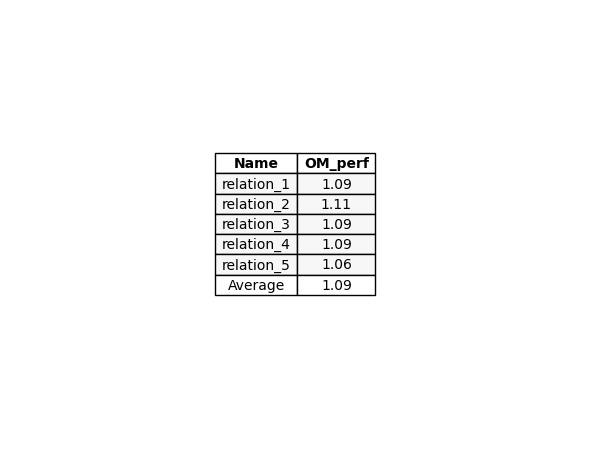

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------
# 1. Clean the DataFrame manually
# ---------------------------------------------------

# df must already exist and contain the OM_perf column
# Auto-detect OM_perf column
om_col = None
for c in df.columns:
    if "om" in c.lower():
        om_col = c
        break

if om_col is None:
    raise ValueError("No OM_perf column found in df. Check the column names.")

# Round OM_perf to 2 decimals
om_values = df[om_col].round(2).tolist()

# MANUALLY set your tag: "relation", "feature", or "response"
tag = "relation"   # <<< CHANGE THIS when needed

# Generate readable names
names = [f"{tag}_{i+1}" for i in range(len(om_values))]

# Build clean DataFrame
clean_df = pd.DataFrame({
    "Name": names,
    "OM_perf": om_values
})

# ---------------------------------------------------
# 2. Add average row
# ---------------------------------------------------
avg_val = clean_df["OM_perf"].mean().round(2)

clean_df = pd.concat([
    clean_df,
    pd.DataFrame({"Name": ["Average"], "OM_perf": [avg_val]})
], ignore_index=True)


# ---------------------------------------------------
# 3. Plot as a table
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(6, len(clean_df)*0.6 + 1))
ax.axis("off")

table = ax.table(
    cellText=clean_df.values,
    colLabels=clean_df.columns,
    cellLoc="center",
    loc="center"
)

# Styling
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Header
        cell.set_text_props(weight="bold", color="black")
        cell.set_facecolor("#ffffff")
    elif row == len(clean_df):
        # Should not trigger, safe guard
        pass
    elif clean_df.iloc[row-1]["Name"] == "Average":
        # Average row styling
        cell.set_facecolor("#e8e8e8")
        cell.set_text_props(weight="bold")
    else:
        # Normal rows
        cell.set_facecolor("#f7f7f7")

table.auto_set_column_width(col=list(range(clean_df.shape[1])))

plt.tight_layout()

plt.savefig("OMperf_table.png", dpi=600, bbox_inches="tight")  # super sharp PNG
plt.savefig("OMperf_table.pdf", bbox_inches="tight")   


plt.show()
